# Instagram Explore feed

Import relevant libraries

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import re
import pandas as pd
import os
import time
import pickle,csv
import matplotlib.pyplot as plt

Functions to save and load cookies

In [2]:
# Save cookie from driver after login
def save_cookie(driver, path):
    with open(path, 'wb') as filehandler:
        pickle.dump(driver.get_cookies(), filehandler)

In [3]:
# Use a saved Cookie
def load_cookie(driver, path):
     with open(path, 'rb') as cookiesfile:
         cookies = pickle.load(cookiesfile)
         for cookie in cookies:
             driver.add_cookie(cookie)

Open Explore Instagram feed and login using the given cookie

In [29]:
url = "https://www.instagram.com/explore/"

# create a new Firefox session
driver = webdriver.Firefox()
driver.implicitly_wait(30)
driver.get(url)
load_cookie(driver,'cookie')
driver.refresh()
actionChain = webdriver.ActionChains(driver)
# Save data to output_insta_3.csv
w = csv.writer(open("data_instagram_part3.csv", "a"))

In [30]:
comments, likes, views, multiple = {}, {}, {}, {}
count, lastImg = 0, 0

In [30]:
actionChain = webdriver.ActionChains(driver)
while len(likes) < 3000:
    img = driver.find_elements_by_class_name('v1Nh3')
    imgLen = len(img)
    i = 0
    while i < imgLen:
        if len(likes) >= 3000:
            break
        try:
            img = driver.find_elements_by_class_name('v1Nh3')
            imgLen = len(img)
            if lastImg:
                if lastImg == img[i-1]:
                    pass
                else:
                    for j in range(imgLen):
                        if lastImg == img[j]:
                            i = j+1
                            break
            actionChain = webdriver.ActionChains(driver)
            hover = actionChain.move_to_element(img[i])
            hover.perform()
            soup=BeautifulSoup(driver.page_source, 'html.parser')
            l = soup.find_all(class_='v1Nh3')
            index = str(re.findall('<a href="[/ \- _ $ % ? a-z A-Z 0-9]*">',str(l[i])))
            index = str(re.findall('/[/ \- _ $ % ? a-z A-Z 0-9]*/',index))
            if 'Carousel' in str(l[i]):
                multiple[index] = 1
            else:
                multiple[index] = 0
            soup=BeautifulSoup(driver.page_source, 'html.parser')
            l = soup.find_all('li', class_='-V_eO')
            if len(l) != 2:
                l = l[len(l)-2:len(l)]
            l1 = l[0].get_text()
            l2 = l[1].get_text()
            comments[index] = l2
            if 'Play' in str(l[0]):
                views[index] = l1
                try:
                    img1 = driver.find_elements_by_class_name('v1Nh3')[i]
                    img1.click()
                    v = driver.find_elements_by_class_name('vcOH2')[0]
                    v.click()
                    soup=BeautifulSoup(driver.page_source, 'html.parser')
                    likeTmp = soup.find(class_='vJRqr').text.strip('likes').strip()
                    likes[index] = likeTmp
                    close = driver.find_elements_by_class_name('ckWGn')[0]
                    close.click()                        
                except Exception as e:
#                     print(e)
                    close = driver.find_elements_by_class_name('ckWGn')[0]
                    close.click()
                    pass
            else :
                likes[index] = l1
                views[index] = -1
            lastImg = img[i]
#             print (index, likes[index],comments[index])
            i += 1
            w.writerow([index, likes[index], comments[index],views[index],multiple[index]])     
#             flag = 1
        except Exception as e:
#             print(e)
#             if flag:
            actionChain = webdriver.ActionChains(driver)
            actionChain.key_down(Keys.PAGE_DOWN).key_up(Keys.PAGE_DOWN).perform()
#                 flag = 0
            time.sleep(3)


InvalidSessionIdException: Message: Tried to run command without establishing a connection


In [31]:
with open("data_instagram_part3.csv") as csvfile:
    data = list(csv.reader(csvfile))
for i in range(len(data)):
    key = data[i][0]
    likes[key], comments[key], views[key] = data[i][1], data[i][2], data[i][3]
    if views[key] == '-1':
        views[key] = '0'
    multiple[key] = data[i][4]

In [32]:
for i in likes:
    if 'k' in str(likes[i]):
        likes[i] = float(likes[i].strip('k'))*1000
        continue
    likes[i] = ''.join(c for c in str(likes[i]) if c.isnumeric())
    likes[i] = int(likes[i])
    
for i in views:
    if 'k' in str(views[i]):
        views[i] = float(views[i].strip('k'))*1000
        continue
    views[i] = ''.join(c for c in str(views[i]) if c.isnumeric())
    views[i] = int(views[i])
    
for i in comments:
    comments[i] = ''.join(c for c in str(comments[i]) if c.isnumeric())
    comments[i] = int(comments[i])
    
multipleCount = 0
for i in multiple:
    multiple[i] = ''.join(c for c in str(multiple[i]) if c.isnumeric())
    multiple[i] = int(multiple[i])
    if multiple[i] == 1:
        multipleCount += 1

In [36]:
popularity = {}
for i in likes:
    popularity[i] = likes[i] + 3*comments[i]
sorted_like = sorted(popularity, key=popularity.get, reverse=True)
for i in range(5):
    print("Popularity Score:",popularity[sorted_like[i]],"ID",sorted_like[i],"Likes:",likes[sorted_like[i]],"Comments:",comments[sorted_like[i]])

Popularity Score: 980784.0 ID ['/p/BwKlgl6hopB/'] Likes: 972000.0 Comments: 2928
Popularity Score: 980609.0 ID ['/p/Bv9soHZFsSF/'] Likes: 968000.0 Comments: 4203
Popularity Score: 917827.0 ID ['/p/BwGF969hC1X/'] Likes: 892000.0 Comments: 8609
Popularity Score: 874922.0 ID ['/p/BwN9xjRn593/'] Likes: 854000.0 Comments: 6974
Popularity Score: 869447.0 ID ['/p/BwMm3rIAmJL/'] Likes: 869000.0 Comments: 149


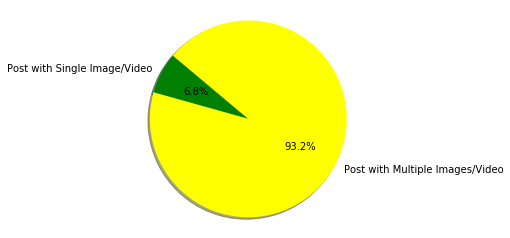

In [34]:
labels = "Post with Single Image/Video", "Post with Multiple Images/Video"
sizes = [multipleCount, 3000-multipleCount]
colors = ['orange', 'blue']
explode = (0, 0)
plt.pie(sizes, explode=(0,0), labels=labels, colors=['green','yellow'], autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()